In [464]:
import numpy as np
import os
import random 
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [465]:
path = '/Volumes/Tianxiao/20240426_EVs/EVs/'
root = '1_100'
file_numbers = 10               # Number of files collected
channelA_thresh = 7    # Threshold for Channel A (Green).
channelB_thresh = 19  # Threshold for Channel B (Red).
channelA_AF = 0.6  # Autofluorescence
channelB_AF = 1.97
xtalk = 0.03  # Cross-talk from A to B

frequency = 10000              # Acquisition rate (in Hz)
acquisition_time = 30          # Duration of each file in seconds
display_set = [5,10,30,60,120,240] # Time spans to perform boostrap

In [466]:
file_list = []
for i in range(file_numbers):
    file_name = f"{root}_{i+1:02d}" if i > 0 else root
    file_list.append(os.path.join(path, file_name))

In [467]:
def load_files(number_of_files):
    channelA = []
    channelB = []  # Where channel B data will be stored
    for i in range(0, number_of_files):

        if(i < 1):
            filename = path + "/" + root
        elif(i < 9):
            filename = path + "/" + root + "_0" + str(i + 1)
        else:
            filename = path + "/" + root + "_" + str(i + 1)
        a = 0  # Row counter
        with open(filename) as csvDataFile:  # Opens the file as a CSV
            csvReader = csv.reader(csvDataFile, delimiter='\t')  # Assigns the loaded CSV file to csvReader.
            for row in csvReader:
                channelA.append(row[0])  # For every row in in csvReader, the values are apended to green and red.
                channelB.append(row[1])
                a += 1

        print("Loaded %s, which contains %s rows." % (filename, a))

    channelA_arr = np.asarray(channelA, dtype=np.float32)  # Converts these to numpy arrays for vector calcs.
    channelB_arr = np.asarray(channelB, dtype=np.float32)
    return channelA_arr, channelB_arr

In [468]:
def get_Q(channelA_arr, channelB_arr):

    # Now need to account for autofluorescence and crosstalk etc.

    channelB_arr = (channelB_arr - xtalk * channelA_arr) - channelB_AF
    channelA_arr = channelA_arr - channelA_AF

    # This part is for the thresholding:

    channelA_only_events = channelA_arr[(channelA_arr > channelA_thresh)]  # Total A events
    channelB_only_events = channelB_arr[(channelB_arr > channelB_thresh)]  # Total B events
    channelA_events = channelA_arr[np.logical_and(
        channelA_arr > channelA_thresh, channelB_arr > channelB_thresh)]  # A coincident events
    channelB_events = channelB_arr[np.logical_and(
        channelA_arr > channelA_thresh, channelB_arr > channelB_thresh)]  # B coincident events

    # Now need to account for chance events:

    channelB_shuffle = channelB_arr.copy()
    np.random.shuffle(channelB_shuffle)

    channelA_chance = channelA_arr[np.logical_and(
        channelA_arr > channelA_thresh, channelB_shuffle > channelB_thresh)]  # These are the chance events
    channelB_chance = channelB_shuffle[np.logical_and(
        channelA_arr > channelA_thresh, channelB_shuffle > channelB_thresh)]

    # Now need to calculate Q value:

    var_real_events = float(len(channelA_events))
    var_A_events = float(len(channelA_only_events))
    var_B_events = float(len(channelB_only_events))
    var_chance_events = float(len(channelA_chance))
    Q = float((var_real_events - var_chance_events) /
            (var_A_events + var_B_events - (var_real_events - var_chance_events)))

    print('There were %s A events, %s B events, %s coincidence events, and %s chance events. Q = %f.' %
        (var_A_events, var_B_events, var_real_events, var_chance_events, Q))

    return Q

In [469]:
def generate_data(channelA_arr, channelB_arr, display_range):
   start_index = random.randint(0, acquisition_time* file_numbers * frequency - display_range * frequency)
   end_index = start_index + display_range * frequency
   bootstrap_channelA = channelA_arr[start_index:end_index]
   bootstrap_channelB = channelB_arr[start_index:end_index]
   return bootstrap_channelA, bootstrap_channelB

In [470]:
channelA_arr, channelB_arr = load_files(file_numbers)
Q_set = []
for display_range in display_set:
    Q_list = []
    for i in range(500):
        bootstrap_channelA, bootstrap_channelB = generate_data(channelA_arr, channelB_arr, display_range)
        Q = get_Q(bootstrap_channelA, bootstrap_channelB)
        Q_list.append(Q)
    Q_set.append(Q_list)

Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_02, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_03, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_04, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_05, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_06, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_07, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_08, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_09, which contains 300100 rows.
Loaded /Volumes/Tianxiao/20240426_EVs/EVs//1_100_10, which contains 300100 rows.
There were 268.0 A events, 461.0 B events, 3.0 coincidence events, and 3.0 chance events. Q = 0.000000.
There were 246.0 A events, 464.0 B events, 2.0 coincidence events, and 4.0 chance events.

In [471]:
Q_set = np.array(Q_set)
Q_set.shape

(6, 500)

In [472]:
df = pd.DataFrame(Q_set)

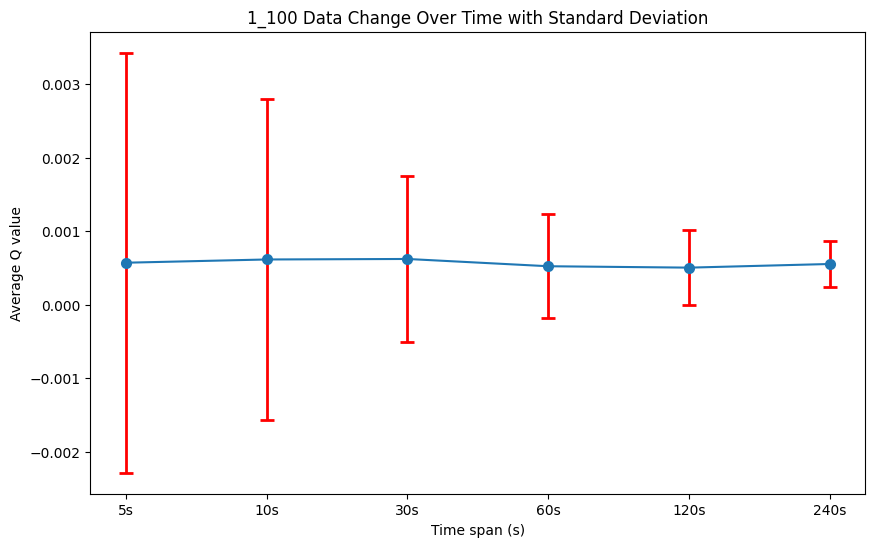

In [473]:
# Calculate mean and standard deviation for each time point (row-wise)
mean_values = df.mean(axis=1)  # Mean of each row
std_deviation = df.std(axis=1)  # Standard deviation of each row

# Plotting the mean values with standard deviation as error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, len(mean_values) + 1), mean_values, yerr=std_deviation, fmt='-o',
             ecolor='red', capsize=5, elinewidth=2, markeredgewidth=2)
plt.title(f'{root} Data Change Over Time with Standard Deviation')
plt.xlabel('Time span (s)')
plt.ylabel('Average Q value')
plt.xticks(ticks=range(1, len(mean_values) + 1), labels=[f'{i}s' for i in display_set])

# output_path = os.path.join(path, root + 'Q_values.png')
plt.savefig(os.path.join(path,root+'Q_values.pdf'),transparent=True)
plt.show()

In [474]:
# for idx, row in df.iterrows():
#     plt.figure(figsize=(8, 4))  # Create a new figure for each row
#     plt.plot(row.values, marker='o')  # Plot the row values
#     plt.title(f'Plot of Kind {idx + 1}')  # Title for each plot
#     plt.xlabel('Column Index')
#     plt.ylabel('Value')
#     plt.grid(True)  # Add a grid for better visualization
#     plt.xticks(range(len(row)))  # Set x-ticks to match the number of columns
#     plt.tight_layout()  # Adjust layout to prevent clipping

The following part will focous on how to generate the events rate.

In [475]:
total_acquisation_time = file_numbers * acquisition_time
green_data_set = []
red_data_set = []
coin_data_set = []
for second in range(total_acquisation_time):
    number_of_green = []
    number_of_red = []
    number_of_coin = []
    for check_point in range(second*frequency,(second+1)*frequency):
        if channelA_arr[check_point] > channelA_thresh:
            number_of_green.append(channelA_arr[check_point])
            if channelB_arr[check_point] > channelB_thresh:
                number_of_coin.append(channelA_arr[check_point])
        if channelB_arr[check_point] > channelB_thresh:
            number_of_red.append(channelB_arr[check_point])
    green_data_set.append(len(number_of_green))
    red_data_set.append(len(number_of_red))
    coin_data_set.append(len(number_of_coin)) 

In [476]:
# x_axis = np.arange(0,total_acquisation_time,1)
# plt.figure(figsize=(10, 6))
# plt.plot(x_axis,green_data_set,label='Green')
# plt.plot(x_axis,red_data_set,label='Red')
# plt.plot(x_axis,coin_data_set,label='Coincidence')
# # plt.plot(sum(green_data_set)/len(green_data_set), color='green', linewidth=10, label='Green Mean')
# # plt.plot(sum(red_data_set)/len(red_data_set), color='red', linewidth=10, label='Red Mean')
# # plt.plot(sum(coin_data_set)/len(coin_data_set), color='blue', linewidth=10, label='Coincidence Mean')
# plt.title(f'{root} Data Change Over Time')
# plt.xlabel('Time (s)')
# plt.ylabel('Event rate (Hz)')
# plt.legend()
# plt.show()

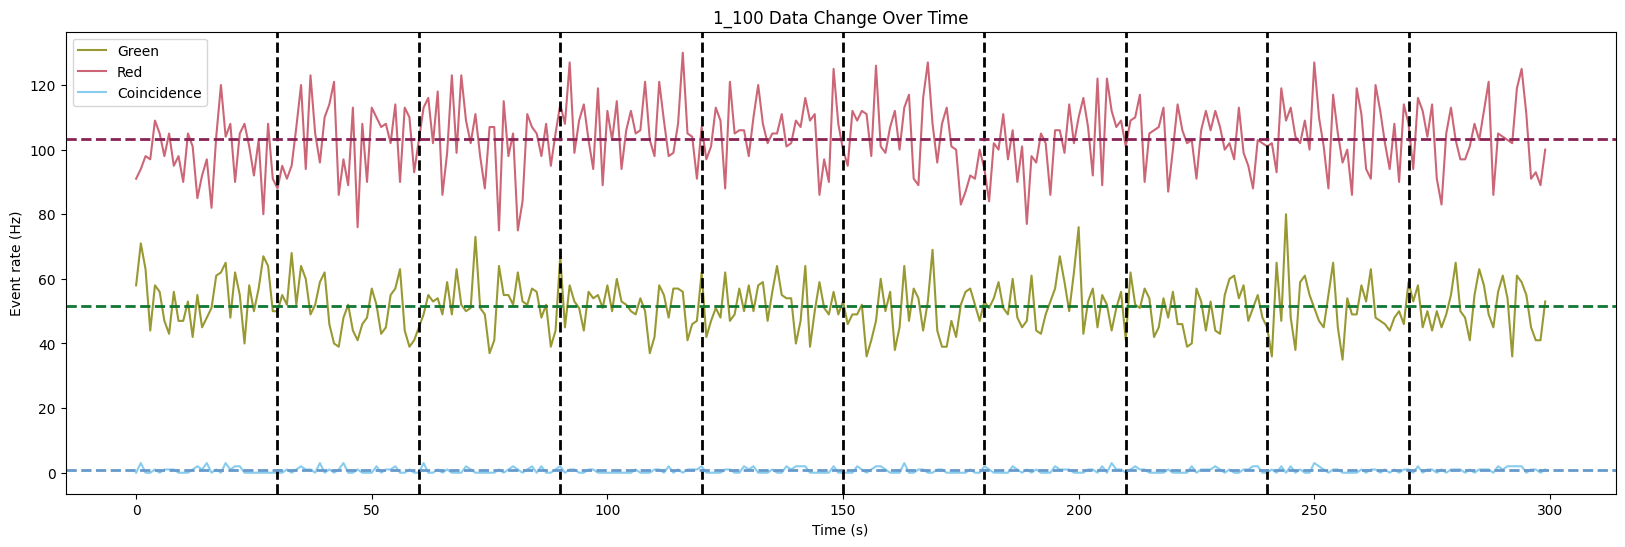

In [477]:
green_color = '#999933'   # A distinct green color
red_color = '#CC6677'     # A distinct red color
blue_color = '#88CCEE'    # A deep blue for Coincidence


x_axis = np.arange(0, total_acquisation_time, 1)

# Calculate the means of each dataset
green_mean = np.mean(green_data_set)
red_mean = np.mean(red_data_set)
coin_mean = np.mean(coin_data_set)

# Plot the data sets
plt.figure(figsize=(20, 6))
plt.plot(x_axis, green_data_set, label='Green', color=green_color)
plt.plot(x_axis, red_data_set, label='Red', color=red_color)
plt.plot(x_axis, coin_data_set, label='Coincidence', color=blue_color)

# Plot the means as horizontal lines
for position in range(1,file_numbers):
    plt.axvline(position*acquisition_time, color='black', linestyle='--', linewidth=2)
plt.axhline(green_mean, color='#117733', linestyle='--', linewidth=2)
plt.axhline(red_mean, color='#882255', linestyle='--', linewidth=2)
plt.axhline(coin_mean, color='#6699CC', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.title(f'{root} Data Change Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Event rate (Hz)')
plt.legend()
plt.savefig(os.path.join(path,root+'_density.pdf'),transparent=True)
plt.show()
